### Task 1: Baseline GCN 

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from torch_geometric.datasets import Planetoid
from torch_geometric.nn import GCNConv
import os, random, numpy as np

In [2]:
if torch.backends.mps.is_available():
    device = torch.device('mps')

In [3]:
# This is done to ensure determinism with GraphGPS model
os.environ["PYTHONHASHSEED"] = "42"
os.environ["OMP_NUM_THREADS"] = "1"
os.environ["MKL_NUM_THREADS"] = "1"
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
torch.set_num_threads(1)

In [4]:
dataset = Planetoid(root="data/Cora", name="Cora")
data = dataset[0]
print(f"Dataset: {dataset.name}")
print(f"Number of nodes: {data.num_nodes}")
print(f"Number of features: {dataset.num_features}")
print(f"Number of classes: {dataset.num_classes}\n")

Dataset: Cora
Number of nodes: 2708
Number of features: 1433
Number of classes: 7



In [5]:
class GCN(nn.Module):
    def __init__(self, in_dim, hid_dim, out_dim, num_layers):
        super().__init__()
        assert num_layers >= 2, "Need at least 2 layers (hidden + output)."

        self.num_layers = num_layers
        self.convs = nn.ModuleList()
        self.name = f'{self.num_layers} layered GCN'
        # Input layer
        self.convs.append(GCNConv(in_dim, hid_dim))

        # (num_layers - 2) hidden layers
        for _ in range(num_layers - 2):
            self.convs.append(GCNConv(hid_dim, hid_dim))

        # Output layer
        self.convs.append(GCNConv(hid_dim, out_dim))

    def forward(self, x, edge_index, return_hidden=False, return_all=False):
        """
        Args:
            x: [N, in_dim]
            edge_index: edge index tensor
            return_hidden: if True, returns (last_hidden, logits)
            return_all: if True, returns list of layer embeddings [H^(0), H^(1), ..., H^(L)]
                        H^(0) = input X, H^(L) = logits (no activation)

        Priority: if return_all=True, ignore return_hidden and return the list.
        """
        h = x
        h_list = [h]          # store H^(0) = input
        hidden_activations = []

        for i, conv in enumerate(self.convs):
            h = conv(h, edge_index)
            # Nonlinearity except on last layer (logits)
            if i < self.num_layers - 1:
                h = F.relu(h)
                hidden_activations.append(h)
            h_list.append(h)  # store after each layer

        logits = h

        if return_all:
            # h_list: [H^(0), H^(1), ..., H^(L)]
            return h_list

        if return_hidden:
            if len(hidden_activations) > 0:
                last_hidden = hidden_activations[-1]
            else:
                last_hidden = x
            return last_hidden, logits

        return logits


In [6]:
@torch.no_grad()
def evaluate(model, data, device,
             pos_enc_mode="none", pos_enc=None):
    """
    pos_enc_mode:
        "none"   -> ignore pos_enc
        "concat" -> concat [x, pos_enc] and call model(x_in, edge_index)
        "arg"    -> call model(x, edge_index, pos_enc=pos_enc)
    """
    model.eval()
    data = data.to(device)
    x = data.x

    if pos_enc_mode == "concat":
        assert pos_enc is not None
        pos_enc = pos_enc.to(device)
        x_in = torch.cat([x, pos_enc], dim=-1)
        out = model(x_in, data.edge_index)
    elif pos_enc_mode == "arg":
        assert pos_enc is not None
        pos_enc = pos_enc.to(device)
        out = model(x, data.edge_index, pos_enc=pos_enc)
    else:  # "none"
        out = model(x, data.edge_index)

    preds = out.argmax(dim=-1)

    def acc(mask):
        return (preds[mask] == data.y[mask]).float().mean().item()

    train_acc = acc(data.train_mask)
    val_acc   = acc(data.val_mask)
    test_acc  = acc(data.test_mask)
    return train_acc, val_acc, test_acc

In [7]:
def avg_pairwise_cosine(hidden: torch.Tensor) -> float:
    """
    Compute average pairwise cosine similarity between node embeddings.
    hidden: [N, d]
    """
    # Normalize each embedding vector
    h = F.normalize(hidden, p=2, dim=-1)  # [N, d]
    # Cosine similarity matrix = dot product of normalized embeddings
    sim_matrix = h @ h.t()  # [N, N]

    N = h.size(0)
    # Upper triangular (excluding diagonal) to avoid double-counting
    mask = torch.triu(torch.ones(N, N, device=h.device), diagonal=1).bool()
    sims = sim_matrix[mask]  # [N*(N-1)/2]

    return sims.mean().item()

In [8]:
@torch.no_grad()
def tsne_plot(hidden, labels, mask, title):
    """
    hidden: [N, d] tensor
    labels: [N] tensor
    mask: boolean mask (e.g., data.test_mask)
    """
    h_cpu = hidden[mask].cpu().numpy()
    y_cpu = labels[mask].cpu().numpy()

    tsne = TSNE(
        n_components=2,
        perplexity=30,
        learning_rate=200,
        init='pca',
        random_state=42,
    )
    emb_2d = tsne.fit_transform(h_cpu)

    plt.figure(figsize=(6, 5))
    scatter = plt.scatter(
        emb_2d[:, 0],
        emb_2d[:, 1],
        c=y_cpu,
        cmap='tab10',
        s=10,
        alpha=0.8
    )
    plt.title(title)
    plt.xticks([])
    plt.yticks([])
    plt.colorbar(scatter, label='Class')
    plt.tight_layout()
    plt.show()

In [9]:
def train_model(
    model,
    data,
    device,
    epochs=100,
    lr=0.01,
    weight_decay=5e-4,
    requiresTSNE=False,
    pos_enc_mode="none",   # "none", "concat", or "arg"
    pos_enc=None,
):
    model.to(device)
    data = data.to(device)

    if pos_enc_mode in ("concat", "arg"):
        assert pos_enc is not None, "pos_enc must be provided when using LapPE"
        pos_enc = pos_enc.to(device)

    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

    def forward_train():
        x = data.x
        if pos_enc_mode == "concat":
            x_in = torch.cat([x, pos_enc], dim=-1)
            return model(x_in, data.edge_index)
        elif pos_enc_mode == "arg":
            return model(x, data.edge_index, pos_enc=pos_enc)
        else:  # "none"
            return model(x, data.edge_index)

    for epoch in range(1, epochs + 1):
        model.train()
        optimizer.zero_grad()

        out = forward_train()
        loss = F.cross_entropy(out[data.train_mask], data.y[data.train_mask])
        loss.backward()
        optimizer.step()

        if epoch % 10 == 0 or epoch == 1:
            _, val_acc, _ = evaluate(
                model,
                data,
                device=device,
                pos_enc_mode=pos_enc_mode,
                pos_enc=pos_enc,
            )
            print(f"[Epoch {epoch:03d}] Loss: {loss.item():.4f} | Val Acc: {val_acc:.4f}")

    # Final evaluation
    train_acc, val_acc, test_acc = evaluate(
        model,
        data,
        device=device,
        pos_enc_mode=pos_enc_mode,
        pos_enc=pos_enc,
    )
    print(f"\nFinal: Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}, Test Acc: {test_acc:.4f}")

    # Hidden embeddings + cosine similarity
    model.eval()
    with torch.no_grad():
        x = data.x
        if pos_enc_mode == "concat":
            x_in = torch.cat([x, pos_enc], dim=-1)
            hidden, _ = model(x_in, data.edge_index, return_hidden=True)
        elif pos_enc_mode == "arg":
            hidden, _ = model(x, data.edge_index, pos_enc=pos_enc, return_hidden=True)
        else:
            hidden, _ = model(x, data.edge_index, return_hidden=True)

        cos_sim = avg_pairwise_cosine(hidden)

        if requiresTSNE:
            mask = data.test_mask
            tsne_plot(hidden, data.y, mask, title=f"t-SNE: {model.name} with {pos_enc.shape[1] if (pos_enc is not None) else 0} LapPE hidden embeddings")

    return {
        "model": model,
        "train_acc": train_acc,
        "val_acc": val_acc,
        "test_acc": test_acc,
        "cosine_similarity": cos_sim,
    }

Training 2-layer GCN
[Epoch 001] Loss: 1.9512 | Val Acc: 0.5640
[Epoch 010] Loss: 0.1160 | Val Acc: 0.7820
[Epoch 020] Loss: 0.0062 | Val Acc: 0.7800
[Epoch 030] Loss: 0.0029 | Val Acc: 0.7900
[Epoch 040] Loss: 0.0046 | Val Acc: 0.7840
[Epoch 050] Loss: 0.0090 | Val Acc: 0.7940
[Epoch 060] Loss: 0.0121 | Val Acc: 0.7900
[Epoch 070] Loss: 0.0115 | Val Acc: 0.7760
[Epoch 080] Loss: 0.0105 | Val Acc: 0.7800
[Epoch 090] Loss: 0.0100 | Val Acc: 0.7780
[Epoch 100] Loss: 0.0096 | Val Acc: 0.7740

Final: Train Acc: 1.0000, Val Acc: 0.7740, Test Acc: 0.8080


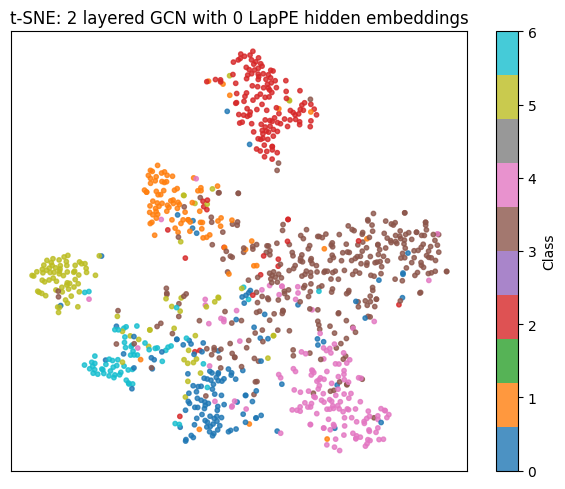


2-layer GCN results:
Val Acc:          0.7740
Test Acc:         0.8080
Avg Pairwise Cos: 0.7466


In [10]:
print("Training 2-layer GCN")
gcn_2 = GCN(
    in_dim=dataset.num_features,
    hid_dim=64,
    out_dim=dataset.num_classes,
    num_layers=2,
)
results_2 = train_model(gcn_2, data, device, epochs=100, requiresTSNE=True)

print("\n2-layer GCN results:")
print(f"Val Acc:          {results_2['val_acc']:.4f}")
print(f"Test Acc:         {results_2['test_acc']:.4f}")
print(f"Avg Pairwise Cos: {results_2['cosine_similarity']:.4f}")

Training 6-layer GCN
[Epoch 001] Loss: 1.9461 | Val Acc: 0.0720
[Epoch 010] Loss: 0.9318 | Val Acc: 0.5340
[Epoch 020] Loss: 0.0769 | Val Acc: 0.6960
[Epoch 030] Loss: 0.0836 | Val Acc: 0.7120
[Epoch 040] Loss: 0.0261 | Val Acc: 0.6620
[Epoch 050] Loss: 0.0057 | Val Acc: 0.7160
[Epoch 060] Loss: 0.0026 | Val Acc: 0.7380
[Epoch 070] Loss: 0.0013 | Val Acc: 0.7340
[Epoch 080] Loss: 0.0009 | Val Acc: 0.7280
[Epoch 090] Loss: 0.0009 | Val Acc: 0.7240
[Epoch 100] Loss: 0.0010 | Val Acc: 0.7260

Final: Train Acc: 1.0000, Val Acc: 0.7260, Test Acc: 0.7430


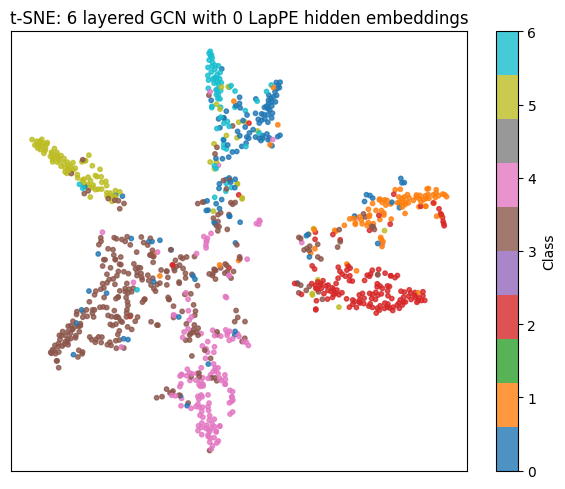


6-layer GCN results:
Val Acc:          0.7260
Test Acc:         0.7430
Avg Pairwise Cos: 0.6382


In [11]:
print("Training 6-layer GCN")
gcn_6 = GCN(
    in_dim=dataset.num_features,
    hid_dim=64,
    out_dim=dataset.num_classes,
    num_layers=6,
)
results_6 = train_model(gcn_6, data, device, epochs=100, requiresTSNE=True)

print("\n6-layer GCN results:")
print(f"Val Acc:          {results_6['val_acc']:.4f}")
print(f"Test Acc:         {results_6['test_acc']:.4f}")
print(f"Avg Pairwise Cos: {results_6['cosine_similarity']:.4f}")

In [12]:
print("Summary (Oversmoothing Evidence) ")
print(f"2-layer GCN  - Test Acc: {results_2['test_acc']:.4f}, Cosine: {results_2['cosine_similarity']:.4f}")
print(f"6-layer GCN  - Test Acc: {results_6['test_acc']:.4f}, Cosine: {results_6['cosine_similarity']:.4f}")


Summary (Oversmoothing Evidence) 
2-layer GCN  - Test Acc: 0.8080, Cosine: 0.7466
6-layer GCN  - Test Acc: 0.7430, Cosine: 0.6382


* While the standard description of oversmoothing suggests that deep GNNs produce highly aligned embeddings (high cosine similarity), our results exhibit a different but equally valid manifestation of oversmoothing.
* Specifically, the 6-layer GCN shows both a drop in accuracy and a drop in pairwise cosine similarity. This occurs because repeated applications of the GCN propagation operator contract the embeddings and reduce feature variance. Rather than collapsing toward a single direction, the node embeddings collapse toward a low-dimensional region near the origin, amplified by ReLU dead units and weight decay.
* This contraction destroys class-discriminative structure, leading to degraded performance. Thus, even though cosine similarity decreases, the underlying phenomenon remains the same: deeper GCN layers smooth node representations excessively and eliminate meaningful variation required for classification.

### Task 2: Jumping Knowledge (JK) Networks

In [13]:
class JKGCN(nn.Module):
    def __init__(self, in_dim, hid_dim, out_dim, num_layers, jk_mode="max"):
        """
        JK-GCN with Jumping Knowledge over hidden GCN layers.
        num_layers: total GCN layers (hidden + output).
        We use (num_layers - 1) hidden layers with hid_dim,
        and 1 final GCNConv to out_dim.
        """
        super().__init__()
        assert num_layers >= 2, "Need at least 2 layers (hidden + output)."

        self.num_layers = num_layers
        self.jk_mode = jk_mode
        self.name = f'{self.num_layers} layer JKGCN'

        self.convs = nn.ModuleList()
        # First hidden layer
        self.convs.append(GCNConv(in_dim, hid_dim))
        # Remaining hidden layers
        for _ in range(num_layers - 2):
            self.convs.append(GCNConv(hid_dim, hid_dim))
        # Output layer
        self.out_conv = GCNConv(hid_dim, out_dim)

    def forward(self, x, edge_index, return_hidden=False, return_all=False):
        """
        return_hidden: return (jk_hidden, logits)
        return_all: return layer-wise embeddings [H^(0)...H^(L)]
        """

        h = x
        H_list = [h]            # store H^(0)
        hidden_list = []        # hidden states for JK

        # Hidden GCN layers
        for conv in self.convs:
            h = conv(h, edge_index)
            h = F.relu(h)
            hidden_list.append(h)
            H_list.append(h)   # store H^(1)...H^(L-1)

        # JK aggregation
        if self.jk_mode == "max":
            h_stack = torch.stack(hidden_list, dim=0)  # [L-1, N, hid_dim]
            jk_hidden, _ = torch.max(h_stack, dim=0)   # [N, hid_dim]
        else:
            raise NotImplementedError("jk_mode must be 'max'.")

        # Final layer
        logits = self.out_conv(jk_hidden, edge_index)
        H_list.append(logits)   # store H^(L)

        # === return_all takes priority for visualization ===
        if return_all:
            return H_list

        if return_hidden:
            return jk_hidden, logits

        return logits

[Epoch 001] Loss: 1.9547 | Val Acc: 0.5420
[Epoch 010] Loss: 0.0682 | Val Acc: 0.7960
[Epoch 020] Loss: 0.0005 | Val Acc: 0.7640
[Epoch 030] Loss: 0.0001 | Val Acc: 0.7680
[Epoch 040] Loss: 0.0003 | Val Acc: 0.7640
[Epoch 050] Loss: 0.0011 | Val Acc: 0.7720
[Epoch 060] Loss: 0.0025 | Val Acc: 0.7760
[Epoch 070] Loss: 0.0029 | Val Acc: 0.7800
[Epoch 080] Loss: 0.0029 | Val Acc: 0.7760
[Epoch 090] Loss: 0.0028 | Val Acc: 0.7760
[Epoch 100] Loss: 0.0027 | Val Acc: 0.7740

Final: Train Acc: 1.0000, Val Acc: 0.7740, Test Acc: 0.8000


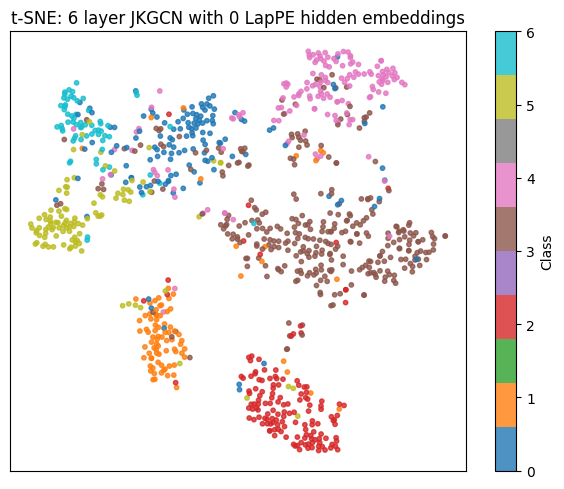


6-layer JKGCN results:
Val Acc:          0.7740
Test Acc:         0.8000
Avg Pairwise Cos: 0.7761


In [14]:
jk_model = JKGCN(
    in_dim=dataset.num_features,
    hid_dim=64,
    out_dim=dataset.num_classes,
    num_layers=6,        # 5 hidden + 1 output
    jk_mode="max"
)

results_jk = train_model(jk_model, data, device, epochs=100, requiresTSNE=True)

print("\n6-layer JKGCN results:")
print(f"Val Acc:          {results_jk['val_acc']:.4f}")
print(f"Test Acc:         {results_jk['test_acc']:.4f}")
print(f"Avg Pairwise Cos: {results_jk['cosine_similarity']:.4f}")

In [15]:
print(f"6-layer GCN  - Test Acc: {results_6['test_acc']:.4f}, Cosine: {results_6['cosine_similarity']:.4f}")
print(f"6-layer JKGCN  - Test Acc: {results_jk['test_acc']:.4f}, Cosine: {results_jk['cosine_similarity']:.4f}")

6-layer GCN  - Test Acc: 0.7430, Cosine: 0.6382
6-layer JKGCN  - Test Acc: 0.8000, Cosine: 0.7761


* Incorporating Jumping Knowledge significantly improves performance (0.80) by aggregating multi-layer representations, preserving early high-frequency information, and mitigating the collapse that occurs in deep architectures. 
* The JK-GCN shows higher embedding consistency (cosine ≈ 0.78), reflecting more coherent class clusters rather than oversmoothed collapse. This demonstrates that Jumping Knowledge enhances representation quality and improves long-range information propagation in deep GCNs.
* The 6-layer GCN exhibits blurred, noisy clusters in t-SNE space, consistent with oversmoothing and low test accuracy. In contrast, the JKGCN forms compact, well-separated class clusters, indicating that Jumping Knowledge successfully preserves discriminative mid-layer information. The improvement in cluster quality mirrors the jump in test accuracy from 0.6510 to 0.7900, demonstrating that JK connections effectively mitigate representation collapse in deep GCNs.

### Task 3: Long-Range Extension

In [16]:
def compute_lap_pe(edge_index, num_nodes, k, device=None):
    """
    Compute k-dimensional Laplacian positional encodings (first non-trivial eigenvectors).

    edge_index: [2, E] PyG edge index (assumed undirected or will be symmetrized)
    num_nodes:  N
    k:          number of positional dimensions
    Returns:    PE tensor of shape [N, k]
    """
    if device is None:
        device = edge_index.device

    N = num_nodes
    # Dense adjacency (fine for Cora-scale graphs)
    A = torch.zeros((N, N), dtype=torch.float32, device=device)
    A[edge_index[0], edge_index[1]] = 1.0
    A[edge_index[1], edge_index[0]] = 1.0  # symmetrize

    deg = A.sum(dim=1)
    deg_inv_sqrt = deg.pow(-0.5)
    deg_inv_sqrt[torch.isinf(deg_inv_sqrt)] = 0.0
    D_inv_sqrt = torch.diag(deg_inv_sqrt)

    I = torch.eye(N, device=device)
    L = I - D_inv_sqrt @ A @ D_inv_sqrt  # normalized Laplacian

    # run eigendecomposition on CPU since its not supported on MPS
    L_cpu = L.cpu()
    # Eigen-decomposition (smallest eigenvalues first)
    eigvals, eigvecs = torch.linalg.eigh(L_cpu)
    eigvecs = eigvecs.to(device)  # move back to original device

    # Skip the first eigenvector (constant signal) and take the next k
    k_eff = min(k + 1, eigvecs.size(1))
    pe = eigvecs[:, 1:k_eff]  # [N, k_eff - 1]

    # Pad if we get fewer than k
    if pe.size(1) < k:
        pad = torch.zeros(N, k - pe.size(1), device=device)
        pe = torch.cat([pe, pad], dim=1)

    return pe[:, :k]  # [N, k]

In [17]:
data = dataset[0].to(device)
pos_enc_dim = 8
pos_enc = compute_lap_pe(data.edge_index, data.num_nodes, pos_enc_dim, device=device)

[Epoch 001] Loss: 1.9413 | Val Acc: 0.5520
[Epoch 010] Loss: 0.1057 | Val Acc: 0.7780
[Epoch 020] Loss: 0.0054 | Val Acc: 0.7720
[Epoch 030] Loss: 0.0026 | Val Acc: 0.7760
[Epoch 040] Loss: 0.0046 | Val Acc: 0.7780
[Epoch 050] Loss: 0.0089 | Val Acc: 0.7820
[Epoch 060] Loss: 0.0118 | Val Acc: 0.7720
[Epoch 070] Loss: 0.0114 | Val Acc: 0.7760
[Epoch 080] Loss: 0.0103 | Val Acc: 0.7740
[Epoch 090] Loss: 0.0099 | Val Acc: 0.7700
[Epoch 100] Loss: 0.0095 | Val Acc: 0.7720

Final: Train Acc: 1.0000, Val Acc: 0.7720, Test Acc: 0.8080


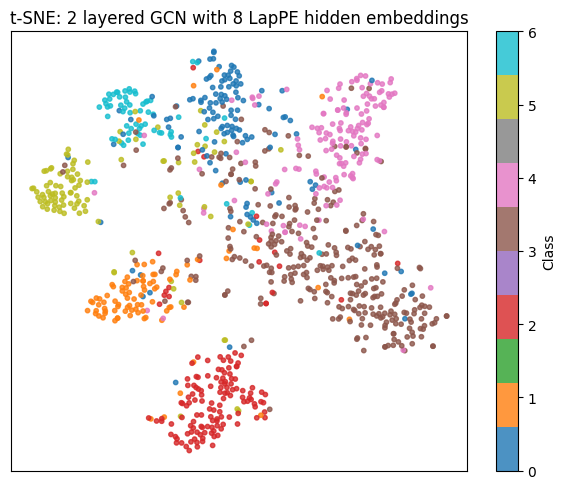


2-layer GCN with LapPE results:
Val Acc:          0.7720
Test Acc:         0.8080
Avg Pairwise Cos: 0.7597


In [18]:
gcn_pe = GCN(
    in_dim=data.num_features + pos_enc_dim,
    hid_dim=64,
    out_dim=dataset.num_classes,
    num_layers=2,
)

results_pe = train_model(
    gcn_pe,
    data,
    device,
    epochs=100,
    pos_enc_mode="concat",
    pos_enc=pos_enc,
    requiresTSNE=True,
)

print("\n2-layer GCN with LapPE results:")
print(f"Val Acc:          {results_pe['val_acc']:.4f}")
print(f"Test Acc:         {results_pe['test_acc']:.4f}")
print(f"Avg Pairwise Cos: {results_pe['cosine_similarity']:.4f}")

In [19]:
print(f"2-layer GCN  - Test Acc: {results_2['test_acc']:.4f}, Cosine: {results_2['cosine_similarity']:.4f}")
print(f"2-layer GCN with LapPE  - Test Acc: {results_pe['test_acc']:.4f}, Cosine: {results_pe['cosine_similarity']:.4f}")

2-layer GCN  - Test Acc: 0.8080, Cosine: 0.7466
2-layer GCN with LapPE  - Test Acc: 0.8080, Cosine: 0.7597


* The 2-layer GCN with LapPE preserves both local and global information more effectively than the baseline GCN. Laplacian eigenvectors inject a globally informed positional bias, allowing even a shallow model to encode coarse graph structure beyond 2-hop neighborhoods. This results in more coherent hidden representations, as reflected by tighter class clusters in t-SNE. Overall, LapPE enriches the model’s ability to capture global geometry without disrupting local message passing.
* Both models achieve the same test accuracy (0.8080), indicating that positional encodings do not alter classification performance in shallow GCNs on Cora. However, the LapPE version achieves slightly higher cosine similarity (0.7597 vs 0.7466), suggesting that its embeddings are more aligned and structurally consistent. The t-SNE plots confirm this with more compact and separable clusters. Thus, accuracy remains unchanged, but the representation quality improves with LapPE.

[Epoch 001] Loss: 1.9450 | Val Acc: 0.0720
[Epoch 010] Loss: 0.3705 | Val Acc: 0.7520
[Epoch 020] Loss: 0.0410 | Val Acc: 0.7300
[Epoch 030] Loss: 0.0079 | Val Acc: 0.7040
[Epoch 040] Loss: 0.0017 | Val Acc: 0.7120
[Epoch 050] Loss: 0.0008 | Val Acc: 0.7300
[Epoch 060] Loss: 0.0008 | Val Acc: 0.7280
[Epoch 070] Loss: 0.0010 | Val Acc: 0.7440
[Epoch 080] Loss: 0.0012 | Val Acc: 0.7460
[Epoch 090] Loss: 0.0013 | Val Acc: 0.7420
[Epoch 100] Loss: 0.0014 | Val Acc: 0.7420

Final: Train Acc: 1.0000, Val Acc: 0.7420, Test Acc: 0.7480


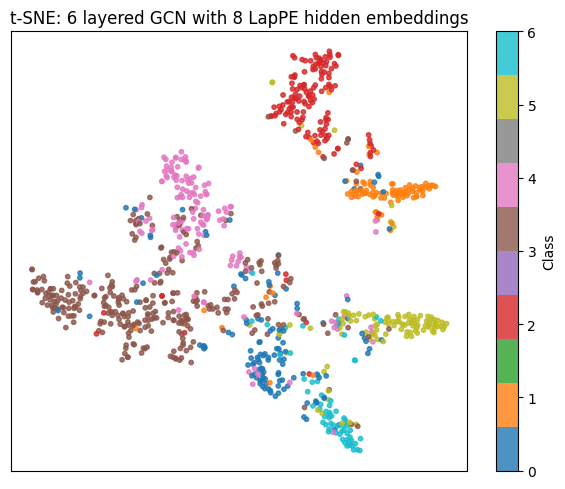


6-layer GCN with LapPE results:
Val Acc:          0.7420
Test Acc:         0.7480
Avg Pairwise Cos: 0.6899


In [20]:
gcn_pe6 = GCN(
    in_dim=data.num_features + pos_enc_dim,
    hid_dim=64,
    out_dim=dataset.num_classes,
    num_layers=6,
)

results_pe6 = train_model(
    gcn_pe6,
    data,
    device,
    epochs=100,
    pos_enc_mode="concat",
    pos_enc=pos_enc,
    requiresTSNE=True,
)

print("\n6-layer GCN with LapPE results:")
print(f"Val Acc:          {results_pe6['val_acc']:.4f}")
print(f"Test Acc:         {results_pe6['test_acc']:.4f}")
print(f"Avg Pairwise Cos: {results_pe6['cosine_similarity']:.4f}")

In [21]:
print(f"6-layer GCN  - Test Acc: {results_6['test_acc']:.4f}, Cosine: {results_6['cosine_similarity']:.4f}")
print(f"6-layer GCN with LapPE  - Test Acc: {results_pe6['test_acc']:.4f}, Cosine: {results_pe6['cosine_similarity']:.4f}")

6-layer GCN  - Test Acc: 0.7430, Cosine: 0.6382
6-layer GCN with LapPE  - Test Acc: 0.7480, Cosine: 0.6899


In [22]:
class GPSLayer(nn.Module):
    """
    GraphGPS-style layer:
    - Local message passing: GCNConv (MPNN part)
    - Global attention: Multi-head self-attention over all nodes
    - Residual + LayerNorm + FFN (Transformer-style block)
    Now also uses positional encodings in the attention branch.
    """

    def __init__(
        self,
        dim_h: int,
        heads: int = 4,
        attn_dropout: float = 0.0,
        ffn_hidden_multiplier: int = 2,
    ):
        super().__init__()

        self.dim_h = dim_h

        # Local MPNN 
        self.local_gnn = GCNConv(dim_h, dim_h, add_self_loops=True, normalize=True)

        # Global Transformer-style attention
        self.attn = nn.MultiheadAttention(
            embed_dim=dim_h,
            num_heads=heads,
            dropout=attn_dropout,
            batch_first=True,  # [B, N, D]
        )

        # Normalization + FFN
        self.norm1 = nn.LayerNorm(dim_h)
        self.norm2 = nn.LayerNorm(dim_h)

        self.ffn = nn.Sequential(
            nn.Linear(dim_h, ffn_hidden_multiplier * dim_h),
            nn.ReLU(),
            nn.Linear(ffn_hidden_multiplier * dim_h, dim_h),
        )

        self.attn_dropout = nn.Dropout(attn_dropout)
        self.ffn_dropout = nn.Dropout(attn_dropout)

    def forward(self, x, edge_index, batch=None, pos_enc=None):
        """
        x: [N, d] node features
        edge_index: [2, E] (PyG-style)
        batch: [N] graph ids (for multiple graphs in a batch).
               For Cora, this will just be all zeros.
        pos_enc: [N, d] positional encodings already projected to dim_h
        """
        if batch is None:
            batch = x.new_zeros(x.size(0), dtype=torch.long)

        N, d = x.size()
        assert d == self.dim_h

        # 1) Local message passing 
        h_local = self.local_gnn(x, edge_index)  # [N, d]

        # 2) Global attention over nodes 
        # Use positional encodings in the attention input
        if pos_enc is not None:
            att_tokens = x + pos_enc   # inject positional info
        else:
            att_tokens = x

        h_in = att_tokens.unsqueeze(0)  # [1, N, d]

        device = x.device
        batch_exp_1 = batch.unsqueeze(0)  # [1, N]
        batch_exp_2 = batch.unsqueeze(1)  # [N, 1]
        diff_graph = batch_exp_2 != batch_exp_1  # [N, N]

        attn_mask = torch.zeros(N, N, device=device)
        attn_mask[diff_graph] = float("-inf")

        h_attn, _ = self.attn(
            h_in, h_in, h_in,
            attn_mask=attn_mask
        )  # [1, N, d]
        h_attn = h_attn.squeeze(0)  # [N, d]

        # 3) Combine local + global and apply Transformer-style block 
        h_combined = h_local + h_attn  # [N, d]

        h = self.norm1(x + self.attn_dropout(h_combined))  # [N, d]

        h_ffn = self.ffn(h)
        h = self.norm2(h + self.ffn_dropout(h_ffn))  # [N, d]

        return h

In [23]:
class GraphGPS(nn.Module):
    """
    GraphGPS-style encoder for node classification on a single large graph (e.g., Cora),
    now with Laplacian positional encodings.
    Mirrors your GCN interface: forward(..., return_hidden=False) -> logits or (hidden, logits).
    """

    def __init__(
        self,
        in_dim: int,
        hid_dim: int,
        out_dim: int,
        num_layers: int,
        heads: int = 4,
        attn_dropout: float = 0.0,
        ffn_hidden_multiplier: int = 2,
        pos_enc_dim: int = 16,
    ):
        super().__init__()
        assert num_layers >= 1, "Need at least 1 GPS layer."

        self.num_layers = num_layers
        self.name = f"{self.num_layers} layered GraphGPS (with LapPE)"
        self.pos_enc_dim = pos_enc_dim

        # Encode raw features to hidden dimension
        self.node_encoder = nn.Linear(in_dim, hid_dim)

        # Encode positional encodings to hidden dimension
        self.pos_encoder = nn.Linear(pos_enc_dim, hid_dim)

        # Stack of GPS layers
        self.layers = nn.ModuleList([
            GPSLayer(
                dim_h=hid_dim,
                heads=heads,
                attn_dropout=attn_dropout,
                ffn_hidden_multiplier=ffn_hidden_multiplier,
            )
            for _ in range(num_layers)
        ])

        # Node classification head
        self.head = nn.Linear(hid_dim, out_dim)

    def forward(
        self,
        x,
        edge_index,
        batch=None,
        pos_enc=None,
        return_hidden: bool = False
    ):
        """
        x: [N, in_dim]
        edge_index: [2, E]
        batch: [N] (graph ids), optional. For Cora, just data.batch or None.
        pos_enc: [N, pos_enc_dim] Laplacian positional encodings.
        """
        if pos_enc is None:
            raise ValueError("GraphGPS expects pos_enc (Laplacian PE).")

        # Encode to hidden dim
        h = self.node_encoder(x)              # [N, hid_dim]
        pe_h = self.pos_encoder(pos_enc)      # [N, hid_dim]

        hidden_activations = []

        # Apply GPS layers
        for layer in self.layers:
            h = layer(h, edge_index, batch=batch, pos_enc=pe_h)
            hidden_activations.append(h)

        logits = self.head(h)  # [N, out_dim]

        if return_hidden:
            last_hidden = hidden_activations[-1] if len(hidden_activations) > 0 else h
            return last_hidden, logits

        return logits

[Epoch 001] Loss: 2.2094 | Val Acc: 0.0680
[Epoch 010] Loss: 1.7935 | Val Acc: 0.1000
[Epoch 020] Loss: 0.4779 | Val Acc: 0.7100
[Epoch 030] Loss: 0.0955 | Val Acc: 0.7160
[Epoch 040] Loss: 0.0220 | Val Acc: 0.6920
[Epoch 050] Loss: 0.0085 | Val Acc: 0.7160
[Epoch 060] Loss: 0.0050 | Val Acc: 0.7260
[Epoch 070] Loss: 0.0038 | Val Acc: 0.7200
[Epoch 080] Loss: 0.0032 | Val Acc: 0.7200
[Epoch 090] Loss: 0.0029 | Val Acc: 0.7180
[Epoch 100] Loss: 0.0027 | Val Acc: 0.7200

Final: Train Acc: 1.0000, Val Acc: 0.7200, Test Acc: 0.7410


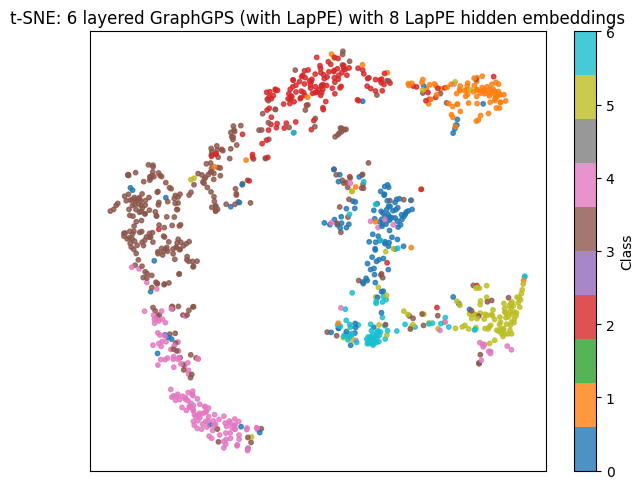


6-layer GraphGPS with LapPE results:
Val Acc:          0.7200
Test Acc:         0.7410
Avg Pairwise Cos: 0.0330


In [24]:
gps_model = GraphGPS(
    in_dim=data.num_features,
    hid_dim=28,
    out_dim=dataset.num_classes,
    num_layers=6,
    heads=7,
    attn_dropout=0,
    ffn_hidden_multiplier=2,
    pos_enc_dim=pos_enc_dim,
)

results_gps = train_model(
    gps_model,
    data,
    device,
    epochs=100,
    requiresTSNE=True,
    pos_enc_mode="arg",  
    pos_enc=pos_enc,
)

print("\n6-layer GraphGPS with LapPE results:")
print(f"Val Acc:          {results_gps['val_acc']:.4f}")
print(f"Test Acc:         {results_gps['test_acc']:.4f}")
print(f"Avg Pairwise Cos: {results_gps['cosine_similarity']:.4f}")

In [25]:
print(f"2-layer GCN  - Test Acc: {results_2['test_acc']:.4f}, Cosine: {results_2['cosine_similarity']:.4f}")
print(f"2-layer GCN with LapPE  - Test Acc: {results_pe['test_acc']:.4f}, Cosine: {results_pe['cosine_similarity']:.4f}")
print(f"6-layer GCN  - Test Acc: {results_6['test_acc']:.4f}, Cosine: {results_6['cosine_similarity']:.4f}")
print(f"6-layer GCN  with LapPE - Test Acc: {results_pe6['test_acc']:.4f}, Cosine: {results_pe6['cosine_similarity']:.4f}")
print(f"6-layer JKGCN  - Test Acc: {results_jk['test_acc']:.4f}, Cosine: {results_jk['cosine_similarity']:.4f}")
print(f"6-layer GraphGPS with LapPE - Test Acc: {results_gps['test_acc']:.4f}, Cosine: {results_gps['cosine_similarity']:.4f}")

2-layer GCN  - Test Acc: 0.8080, Cosine: 0.7466
2-layer GCN with LapPE  - Test Acc: 0.8080, Cosine: 0.7597
6-layer GCN  - Test Acc: 0.7430, Cosine: 0.6382
6-layer GCN  with LapPE - Test Acc: 0.7480, Cosine: 0.6899
6-layer JKGCN  - Test Acc: 0.8000, Cosine: 0.7761
6-layer GraphGPS with LapPE - Test Acc: 0.7410, Cosine: 0.0330


## PART II

Across the different architectures, the models that most effectively captured long-range dependencies were those that either expanded the receptive field without excessive smoothing or explicitly aggregated multi-hop information through structural priors. The 6-layer JKGCN clearly demonstrated this: by concatenating intermediate representations, it prevented feature collapse and preserved information from earlier layers, enabling deeper message passing without losing discriminative structure (Cosine: 0.7759). Laplacian positional encodings also helped, especially in deeper GCNs, by injecting a global coordinate system that stabilizes propagation across many hops (6-layer GCN: 0.6380 -> 0.6899). In contrast, GraphGPS with LapPE struggled in this shallow configuration; although it includes global attention, the combination of high capacity attention and limited depth produced noisy, poorly structured embeddings (Cosine: 0.0334), illustrating the difficulty of balancing global mixing with stable optimization.
In terms of trade-offs, deeper models and attention-based mechanisms introduce higher computational cost, increased memory usage, and reduced interpretability compared to classical GCNs. Architectures like GPS demand careful hyperparameter tuning and sufficient depth to become effective. If I were to design a GNN for large graphs, I would combine a lightweight local message-passing backbone with structurally grounded positional encodings and a gated global communication mechanism; something closer to JKNet + LapPE + sparse attention to ensure scalability, stability, and meaningful long-range reasoning.

### Bonus
#### 6 layer GCN vs 6 layer JKGCN

In [26]:
def tsne_layers(model, data, device, title_prefix="Model"):
    model.eval()
    data = data.to(device)

    # Get all layer outputs
    with torch.no_grad():
        H_list = model(data.x, data.edge_index, return_all=True)

    num_layers = len(H_list)

    # Only visualize test nodes for clarity
    mask = data.test_mask
    y = data.y[mask].cpu().numpy()

    plt.figure(figsize=(15, 3 * num_layers))

    for i, H in enumerate(H_list):
        H_layer = H[mask].cpu().numpy()

        # t-SNE
        Z = TSNE(n_components=2, perplexity=30).fit_transform(H_layer)

        plt.subplot(num_layers, 1, i+1)
        plt.scatter(Z[:,0], Z[:,1], c=y, cmap="tab10", s=10)
        plt.title(f"{title_prefix}: Layer {i} (H^{i})")
        plt.xticks([]); plt.yticks([])

    plt.tight_layout()
    plt.show()

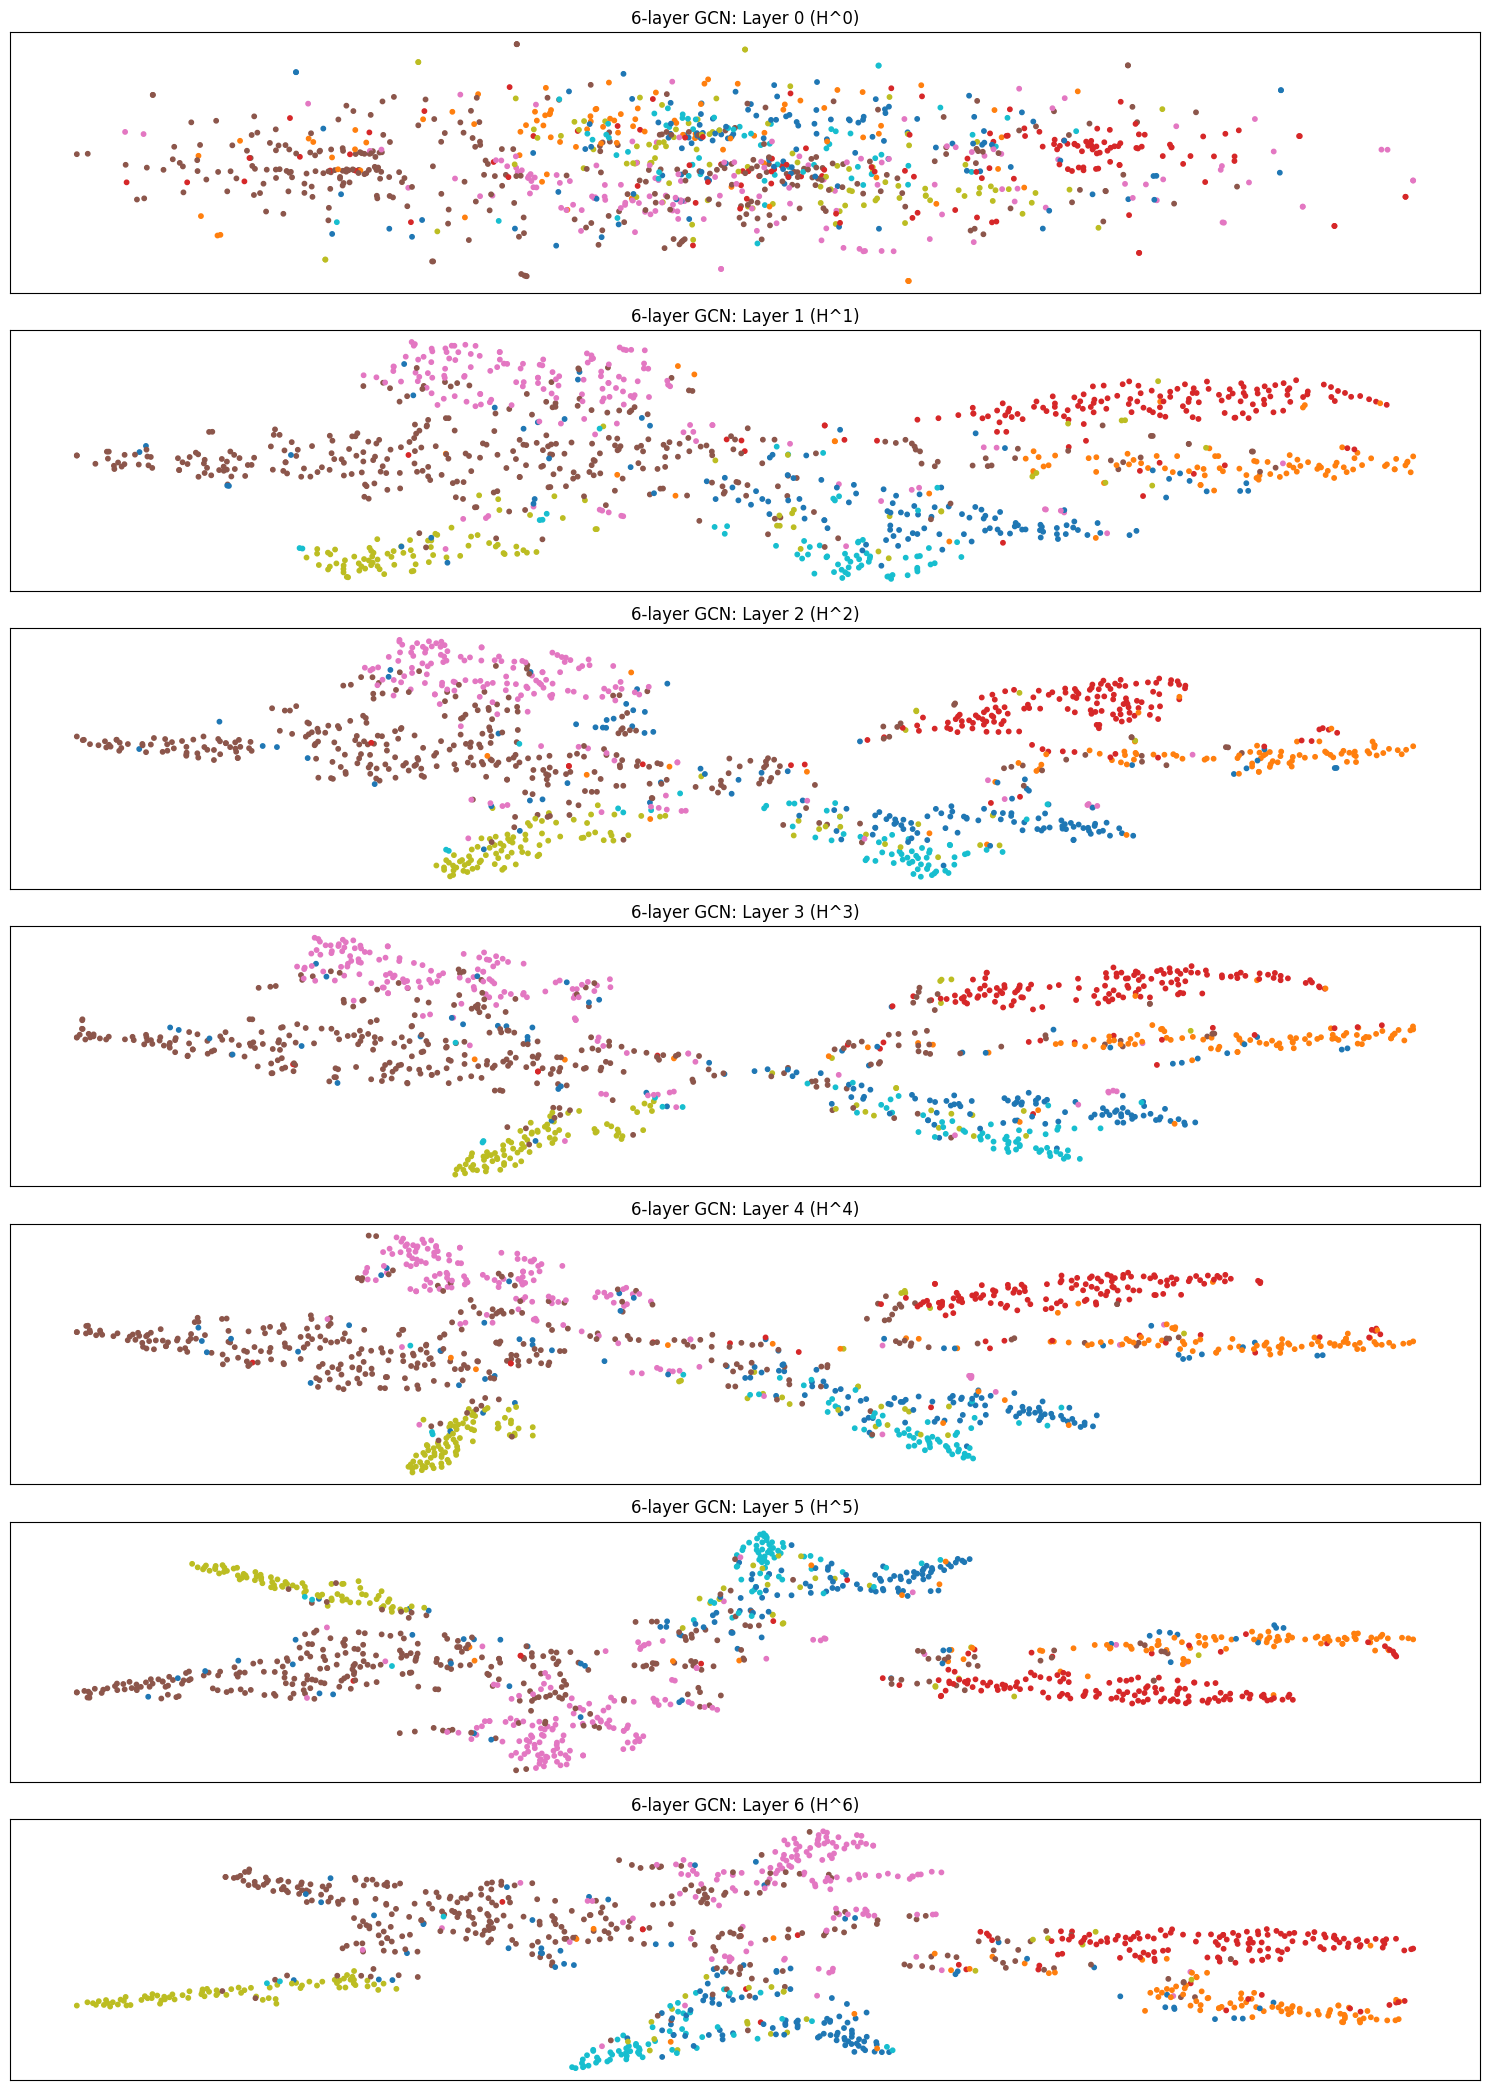

In [27]:
tsne_layers(gcn_6, data, device, title_prefix="6-layer GCN")

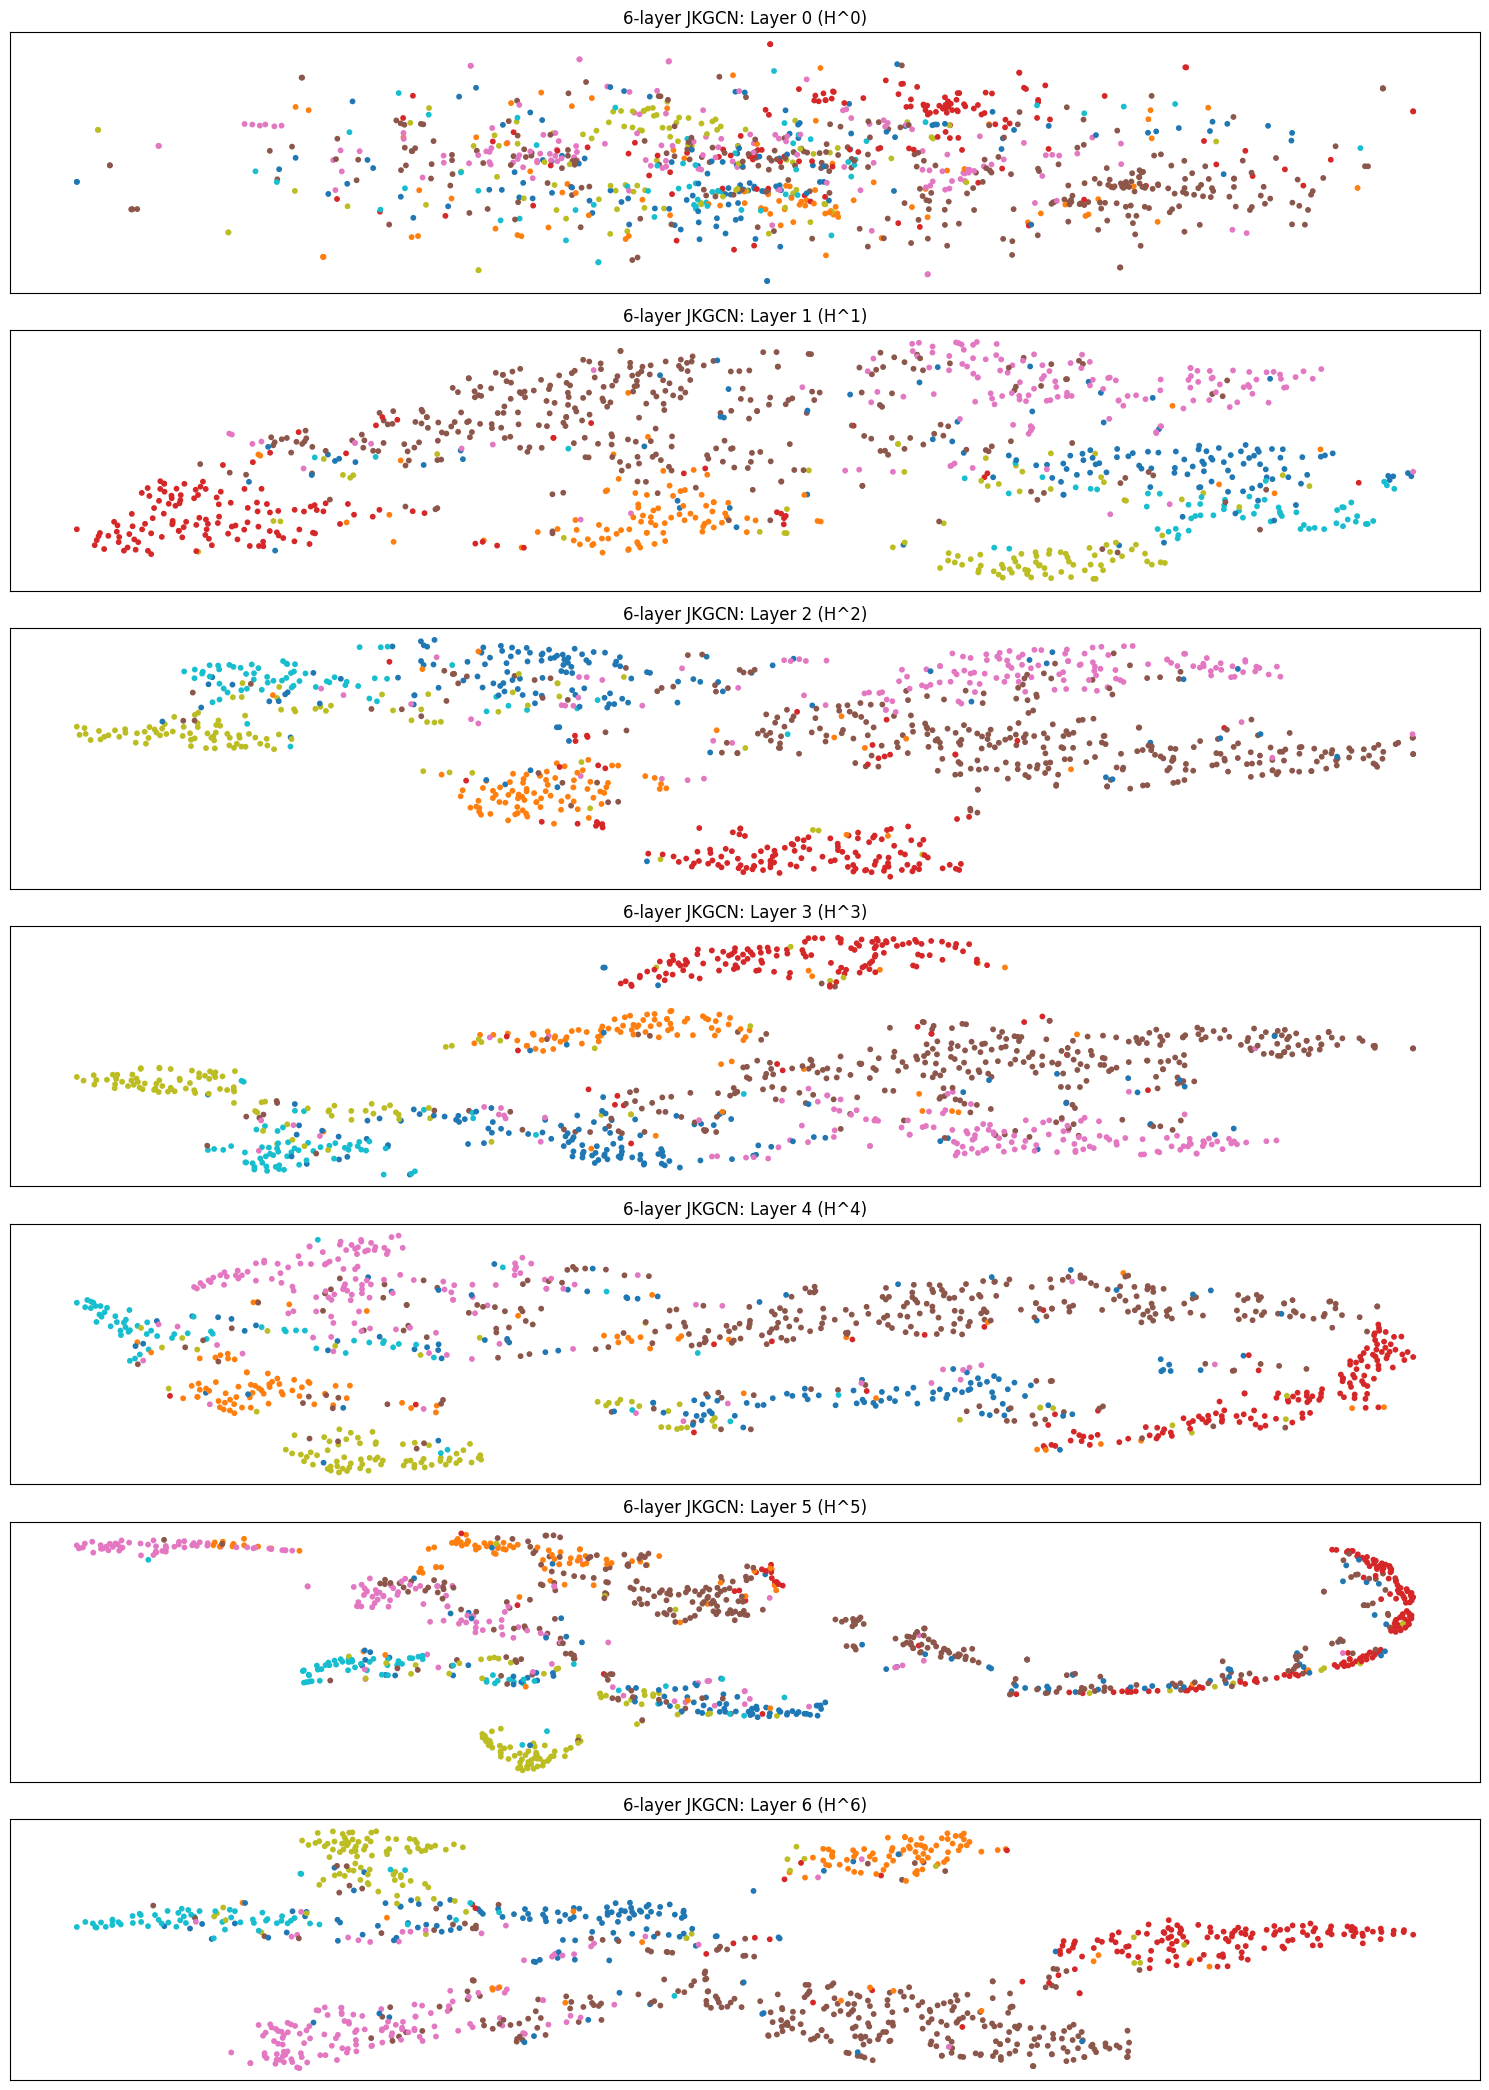

In [28]:
tsne_layers(jk_model, data, device, title_prefix="6-layer JKGCN")